# Reprojection and Regridding

This notebook demonstrates regridding input data for the pan-Arctic datasets

In [14]:
from pathlib import Path

import rioxarray as riox
import xarray as xr

from affine import Affine

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pyproj import CRS

DATAPATH = Path(".") / ".." / "data"

example_file = DATAPATH / "NSIDC0051_SEAICE_PS_N25km_20220531_v2.0.nc"

`rioxarray.rio.project` needs information about the target projection and grid definition.  Projection information can be provided as an EPSG code, a proj4 string or a Well Known Text (WKT).  Unfortunately, the EPSG code for the EASE Grid North Projection (3408) has been depreciated.  `gdal` defaults to the EASE Grid v2.0 North projection.  **This is the wrong projection**. So the projection must be defined using either a proj4 string or WKT.  We use a proj4 string. 

This is because of the reference datum not being fully specified _confirm this_.

In [2]:
EASE_Grid_North = "+proj=laea +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +R=6371228 +units=m +no_defs +type=crs"

In [16]:
EASEGridNorth = CRS.from_proj4(EASE_Grid_North)

In [17]:
EASEGridNorth.to_dict()

/home/apbarret/anaconda3/envs/beer_lambert_rt/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


{'proj': 'laea',
 'lat_0': 90,
 'lon_0': 0,
 'x_0': 0,
 'y_0': 0,
 'R': 6371228,
 'units': 'm',
 'no_defs': None,
 'type': 'crs'}

The grid definition tells the reprojection tools the size of grid cells, the size of the grid and the x and y projected coordinates of the grid.  We want to reproject and resample the data to the 721 x 721 25 km EASE Grid.  The grid parameters for this grid are:

| Parameter | Value |
|-----------|-------|
| Number of Columns | 721 |
| Number of Rows | 721 |
| Pixel width in m | 25067.53 | 
| Pixel height in m | -25067.53 | 
| x-axis map coordinate of the outer edge of the upper-left pixel | -9036842.76	|
| y-axis map coordinate of the outer edge of the upper-left pixel |  9036842.76 |

This information is taken from this table of [EASE Grid parameters](https://nsidc.org/data/user-resources/help-center/guide-ease-grids#anchor-9).  You'll notice that in the table above, the pixel height is negative.  This is because the grid origin is the corner of the upper left pixel.  Pixels below this upper-left pixel will be less than the y-axis coordinate _Not the best description_.

In [3]:
columns = 721
rows = 721
pixel_width_m = 25067.5
pixel_height_m = -25067.5
grid_origin_x_m = -9036842.76
grid_origin_y_m = 9036842.76

We can now define a `GeoTransform`.  This is an Affine matrix that is used by gdal to calculate x and y coordinates of pixels.

$$
$$

In [4]:
geotransform = (grid_origin_x_m, pixel_width_m, 0., grid_origin_y_m, 0., pixel_height_m)
grid_definition = Affine.from_gdal(*geotransform)
grid_definition

Affine(25067.5, 0.0, -9036842.76,
       0.0, -25067.5, 9036842.76)

In [5]:
ds = xr.open_dataset(example_file, decode_coords="all")
ds

<xarray.Dataset>
Dimensions:     (x: 304, y: 448, time: 1)
Coordinates:
    crs         |S1 ...
  * x           (x) float64 -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
  * y           (y) float64 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
  * time        (time) datetime64[ns] 2022-05-31
Data variables:
    F17_ICECON  (time, y, x) float32 ...
Attributes: (12/49)
    title:                     Sea Ice Concentrations from Nimbus-7 SMMR and ...
    summary:                   This data set is generated from brightness tem...
    id:                        10.5067/MPYG15WAA4WX
    license:                   Access Constraint: These data are freely, open...
    acknowledgment:            These data are produced by the NASA Cryospheri...
    metadata_link:             https://doi.org/10.5067/MPYG15WAA4WX
    ...                        ...
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east
    product_version:           v2.0
    source:                    Polar stereographic brightness temperatures fr...
    instrument:                SSMIS > Special Sensor Microwave Imager/Sounder
    platform:                  DMSP 5D-3/F17 > Defense Meteorological Satelli...

In [8]:
ds_ease = ds.rio.reproject(EASE_Grid_North, transform=grid_definition, shape=(columns, rows))
ds_ease

<xarray.Dataset>
Dimensions:     (x: 721, y: 721, time: 1)
Coordinates:
  * x           (x) float64 -9.024e+06 -8.999e+06 ... 8.999e+06 9.024e+06
  * y           (y) float64 9.024e+06 8.999e+06 ... -8.999e+06 -9.024e+06
  * time        (time) datetime64[ns] 2022-05-31
    crs         int64 0
Data variables:
    F17_ICECON  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/49)
    title:                     Sea Ice Concentrations from Nimbus-7 SMMR and ...
    summary:                   This data set is generated from brightness tem...
    id:                        10.5067/MPYG15WAA4WX
    license:                   Access Constraint: These data are freely, open...
    acknowledgment:            These data are produced by the NASA Cryospheri...
    metadata_link:             https://doi.org/10.5067/MPYG15WAA4WX
    ...                        ...
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east
    product_version:           v2.0
    source:                    Polar stereographic brightness temperatures fr...
    instrument:                SSMIS > Special Sensor Microwave Imager/Sounder
    platform:                  DMSP 5D-3/F17 > Defense Meteorological Satelli...

In [18]:
EASEGridNorth_ccrs = ccrs.CRS(EASEGridNorth.to_dict())

In [19]:
EASEGridNorth_ccrs

<Derived Projected CRS: +proj=laea +ellps=WGS84 +lat_0=90 +lon_0=0 +x_0=0  ...>
Name: unknown
Axis Info [cartesian]:
- E[south]: Easting (metre)
- N[south]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Azimuthal Equal Area (Spherical)
Datum: unknown
- Ellipsoid: unknown
- Prime Meridian: Greenwich

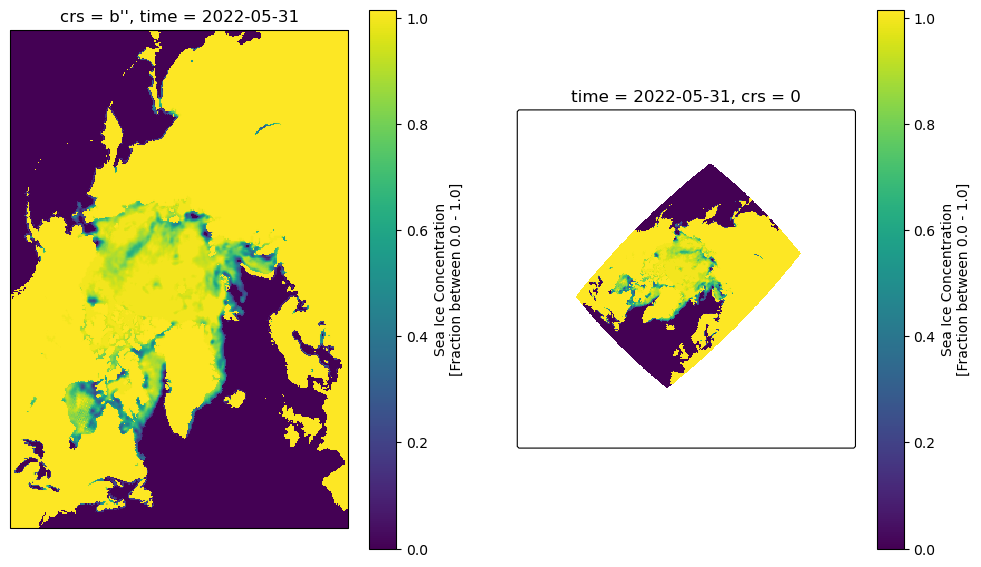

In [23]:
EASEGridNorth_ccrs = ccrs.LambertAzimuthalEqualArea(central_longitude=0., central_latitude=90., 
                                                    globe=ccrs.Globe(semimajor_axis=6371228))
fig = plt.figure(figsize=(12, 7))

ax1 = fig.add_subplot(121, projection=EASEGridNorth_ccrs)
ax2 = fig.add_subplot(122, projection=EASEGridNorth_ccrs)

ds.F17_ICECON[0,:,:].plot.imshow(ax=ax1, interpolation="none")
ax1.set_extent()
    
ds_ease.F17_ICECON[0,:,:].plot.imshow(ax=ax2, interpolation="none")